# データローダのテスト 
画像とスカラー値を同時にあつかえるローダを作る

In [1]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## サンプルの作成
16x16の画像とファイルパス、スカラ値を２つ以上もつcsvを作る

In [2]:
base_path = r'./sample/img/'
os.makedirs(base_path,exist_ok=True) 
list = []
for i in range(100):
    imgdata = np.full((16,16),i*2)
    pil_image = Image.fromarray(imgdata.astype(np.uint8))
    bfn = os.path.basename(f'img_{i}.png')
    out_path = os.path.join( base_path , bfn)
    pil_image.save(out_path)
    list.append( [i , out_path , i*2 , i**2 ])
    pass
df = pd.DataFrame(list,columns=['id','path','value1','value2'])
csv_path = './sample/dataset.csv'
df.to_csv(csv_path)

In [3]:
df = pd.read_csv(csv_path,index_col=0)
df.head(2)

,id,path,value1,value2
0,0,./sample/img/img_0.png,0,0
1,1,./sample/img/img_1.png,2,1


In [285]:
class ImgValPare(Dataset):
    def __init__(self, csv_filepath, transform):
        ## pandas便利だけど永続化できないので、num_workersが使えなくなる
        ## 破棄すること
        csv_df = pd.read_csv(csv_path,index_col=0)
        csv_df['value1'] = csv_df['value1'].astype(np.float16)
        csv_df['value2'] = csv_df['value2'].astype(np.float16)

        self.img_pathlist  = csv_df['path'].to_list()
        self.val1_list  = csv_df['value1'].to_list()
        self.val2_list  = csv_df['value2'].to_list()
        self.transform = transform

    def __len__(self):  
        return len( self.img_pathlist )
    
    def __getitem__(self, index):
        # 画像をPILとして読み込む
        #print(index)
        image = Image.open(self.img_pathlist[index])
        image = image.convert("L") 
        #numpy_img = np.asarray(image, np.float32) / 255.0
        #tensor_img = np.expand_dims(image, axis=0) # このままだとNWHCの形式
        
        label = self.val1_list[index]
        extend = self.val2_list[index]                         
        if self.transform is not None:
            ##print('use transform')
            image = self.transform(image)
        return image, label ,extend
    pass

In [286]:
myDataset = ImgValPare( csv_path ,transform=transforms.ToTensor())

In [287]:
len(myDataset)

100

In [288]:
myDataset[0][0].shape

torch.Size([1, 16, 16])

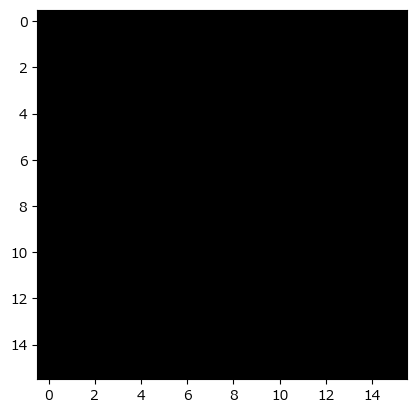

In [289]:
ts = transforms.ToPILImage()
im = ts(myDataset[0][0])
#display(im.size)
plt.imshow(np.array(im),  cmap='gray')

In [290]:
## 学習とテストに分割
n_samples = len(myDataset)
train_size = int( len(myDataset) * 0.8 ) # 教師データのサイズ 全体の80%とする
test_size = n_samples - train_size  # テスト用データのサイズ
train_data, test_data = torch.utils.data.random_split(
        myDataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(0)  # 乱数シードの固定
    )

In [291]:
len(train_data) , len(test_data)

(80, 20)

In [292]:
batch_size = 32
## DataLoader worker (pid(s) 14912) exited unexpectedly メモリ不足
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=0)

In [293]:
images, labels ,extend   = next(iter(train_loader))
len(labels)
images.shape

torch.Size([32, 1, 16, 16])

このローダでNetを組んでみる

In [389]:
class Net( nn.Module ):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=32 , kernel_size = 3, padding=1 , stride=1)
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        ## ここで [32, 256, 4, 4]
        self.fc1 = nn.Linear(in_features= (256*4*4) + 1, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=1)
    def forward(self, x_and_extend):
        x =x_and_extend[0]
        x2 = x_and_extend[1]
        #print('in',x.shape)
        x = F.relu(self.conv1_1(x))
        #print('conv1_1',x.shape)
        x = F.relu(self.conv1_2(x))
        #print('conv1_2',x.shape)
        x = self.pool1(x)
        #print('pool1',x.shape , len(x.flatten()) )
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        #print('pool2',x.shape ,  len(x.flatten()))
        
        x = x.view(-1, self.num_flat_features(x))
        print('view',x.shape , len(x.flatten()))
        print(x)
        print('x2',x2.shape )
        x3 = x2.unsqueeze(dim=1)
        print('x3',x3.shape )
        x = torch.cat([x, x3], dim=1) 
        print(x.dtype , x3.dtype)
        print('cat',x.shape , len(x.flatten()))
        print(x)
        x = self.fc1(x)
        print('fc1',x.shape ,  len(x.flatten()))
        x = self.fc2(x)
        print('fc2',x.shape ,  len(x.flatten()))
        
        return x  
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        #print(num_features)
        return num_features
    pass

In [390]:
net = Net()
print(net)

Net(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4097, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [391]:
## 損失関数
criterion = nn.MSELoss()

In [392]:
## 最適化
optimizer = optim.SGD(net.parameters(), lr=0.01)



In [397]:
##https://venoda.hatenablog.com/entry/2020/10/14/071440
##https://aidiary.hatenablog.com/entry/20180221/1519223357

num_epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)
net.train()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    net.train()
    # 損失和
    epoch_loss = 0.0
    # epochの正解数
    epoch_corrects = 0
    for inputs, labels ,extend in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        extend = extend.to(device,dtype=torch.float32)
        # 勾配を初期化する
        optimizer.zero_grad()
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(True):
            outputs = net([inputs,extend])
             # ラベルを予測
            _, preds = torch.max(outputs, 1)
            # 損失関数を使って損失を計算する
            loss = criterion(outputs.to(torch.float64), labels)
             # 誤差を逆伝搬する
            loss.backward()
            # パラメータを更新する
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
            epoch_corrects += torch.sum(preds == labels.data)
    # 1エポックでの損失を計算
    epoch_loss = epoch_loss / len(train_loader.dataset)
    # 1エポックでの正解率を計算
    epoch_acc = epoch_corrects.double() / len(train_loader.dataset)
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    break
        

cpu
Epoch 1/30
-------------
view torch.Size([32, 4096]) 131072
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0285, 0.0287, 0.0195],
        [0.0035, 0.0000, 0.0000,  ..., 0.0611, 0.0578, 0.0603],
        [0.0000, 0.0000, 0.0000,  ..., 0.0332, 0.0324, 0.0252],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0319, 0.0315, 0.0234],
        [0.0000, 0.0000, 0.0000,  ..., 0.0345, 0.0339, 0.0277],
        [0.0003, 0.0000, 0.0000,  ..., 0.0552, 0.0520, 0.0531]],
       grad_fn=<ViewBackward0>)
x2 torch.Size([32])
x3 torch.Size([32, 1])
torch.float32 torch.float32
cat torch.Size([32, 4097]) 131104
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.8702e-02, 1.9480e-02,
         6.4000e+01],
        [3.4673e-03, 0.0000e+00, 0.0000e+00,  ..., 5.7821e-02, 6.0253e-02,
         4.9000e+03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.2382e-02, 2.5158e-02,
         3.6100e+02],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.1469e-02, 2.3442e-02,
         2.2500e+02],


In [395]:
extend.dtype

torch.float64

In [301]:
labels.dtype

torch.float64

In [265]:
type(labels.shape[0])

int

In [396]:
extend

tensor([3.6100e+02, 6.8880e+03, 9.6000e+03, 4.3560e+03, 5.2900e+02, 6.2500e+02,
        6.0840e+03, 3.6000e+01, 7.2240e+03, 8.8320e+03, 3.8440e+03, 2.5600e+02,
        5.7760e+03, 1.9360e+03, 0.0000e+00, 8.1000e+03, 9.0240e+03, 5.7600e+02,
        1.0000e+00, 7.9200e+03, 1.3690e+03, 7.8400e+02, 2.5000e+01, 1.2100e+02,
        3.0240e+03, 2.7040e+03, 5.9280e+03, 1.2960e+03, 8.4100e+02, 6.5600e+03,
        1.7640e+03, 9.2160e+03], dtype=torch.float64)